# Lab 6
### Morphology

Skimage morphology operators' documentation:
https://scikit-image.org/docs/dev/api/skimage.morphology.html

In [1]:
from commonfunctions import *
import numpy as np
import skimage.io as io
from skimage import filters, measure
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin, square
from skimage.measure import find_contours
from skimage.draw import rectangle

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

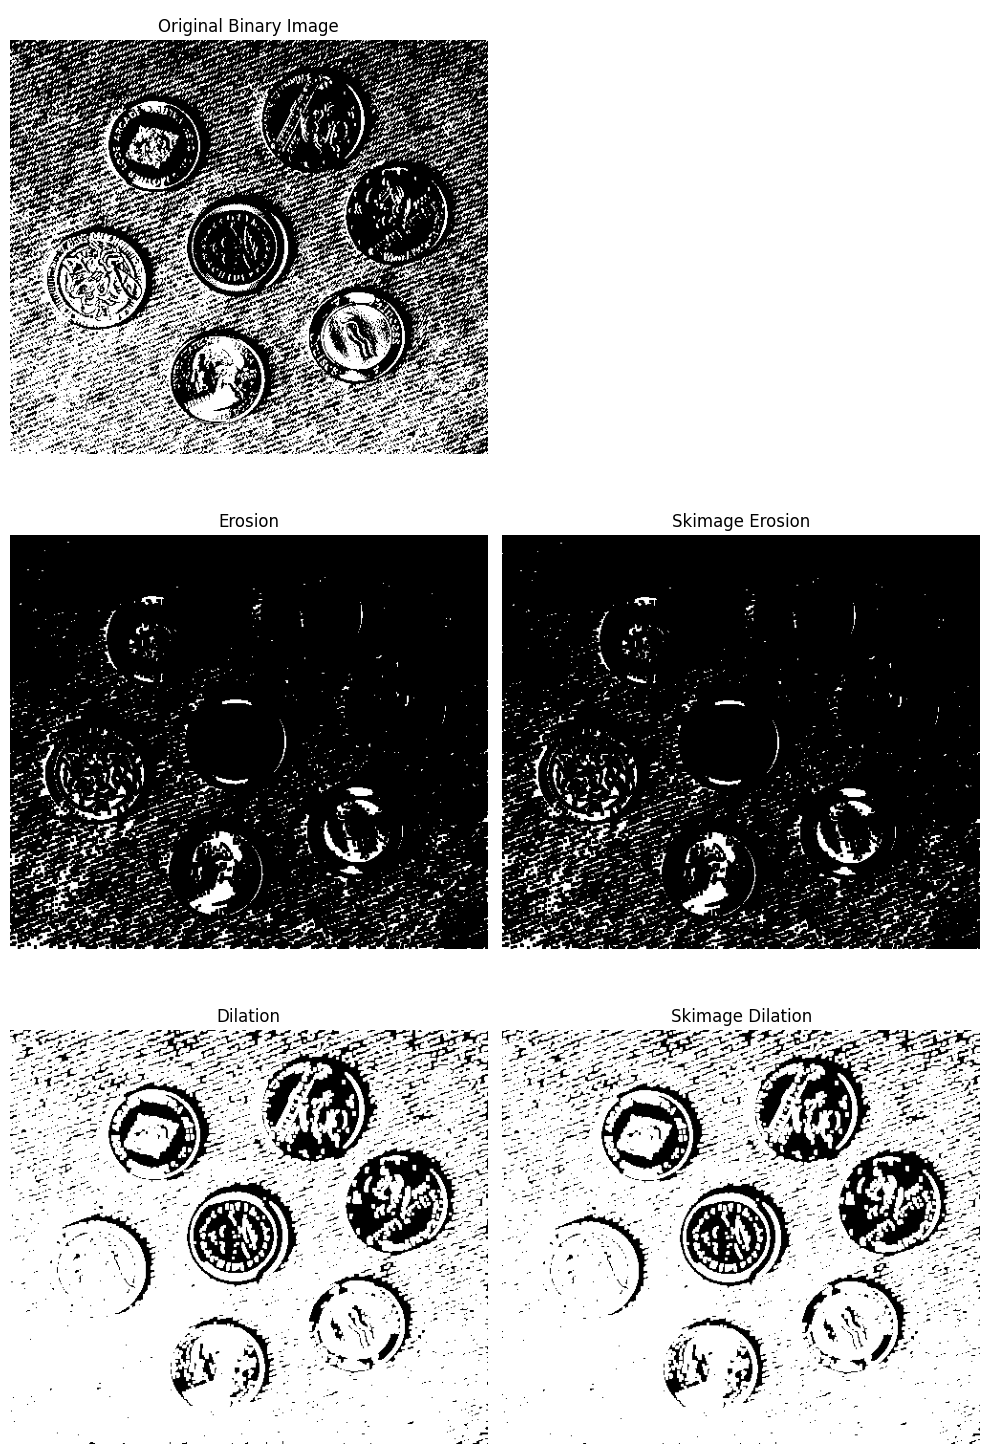

In [12]:
'''
1) Erosion / Dilation:
    - Load "coins.jpg" from the img folder
    - Convert the image to binary
    - Write 2 functions each applying 1 of the erosion/dilation algorithms (with adjustable square window size) manually to the binary image
    - Use Skimage's "binary_erosion" & "binary_dilation" & show the results
'''
coins_img = io.imread('img/coins.jpg')
coins_img_gray = rgb2gray(coins_img)
# Otsu's method, is used to perform automatic image thresholding.[1] 
# In the simplest form, the algorithm returns a single intensity threshold 
# that separate pixels into two classes foreground and background. 
threshold = filters.threshold_otsu(coins_img_gray)
coins_binary_image = coins_img_gray > threshold

# here we consider all positions in the SE
def erosion(binary_img, window_size):  
    eroded_img = np.zeros_like(binary_img)
    
    for i in range(binary_img.shape[0]):
        for j in range(binary_img.shape[1]):
            curr_window = binary_img[i:i + window_size, j:j + window_size]
            eroded_img[i, j] = np.min(curr_window)  # Fit
    
    return eroded_img

def dilation(binary_img, window_size):
    dilated_img = np.zeros_like(binary_img)
    
    for i in range(binary_img.shape[0]):
        for j in range(binary_img.shape[1]):
            curr_window = binary_img[i:i + window_size, j:j + window_size]
            dilated_img[i, j] = np.max(curr_window)  # Hit 
    
    return dilated_img

window_size = 3
coins_eroded = erosion(coins_binary_image, window_size)
coins_dilated = dilation(coins_binary_image, window_size)

SE = np.ones((window_size, window_size), dtype=int)
skimage_eroded = binary_erosion(coins_binary_image, SE)
skimage_dilated = binary_dilation(coins_binary_image, SE)

fig, ax = plt.subplots(3, 2, figsize=(10, 15))

ax[0, 0].imshow(coins_binary_image, cmap='gray')
ax[0, 0].set_title('Original Binary Image')
ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[1, 0].imshow(coins_eroded, cmap='gray')
ax[1, 0].set_title('Erosion')
ax[1, 0].axis('off')
ax[1, 1].imshow(skimage_eroded, cmap='gray')
ax[1, 1].set_title('Skimage Erosion')
ax[1, 1].axis('off')
ax[2, 0].imshow(coins_dilated, cmap='gray')
ax[2, 0].set_title('Dilation')
ax[2, 0].axis('off')
ax[2, 1].imshow(skimage_dilated, cmap='gray')
ax[2, 1].set_title('Skimage Dilation')
ax[2, 1].axis('off')
plt.tight_layout()
plt.show()


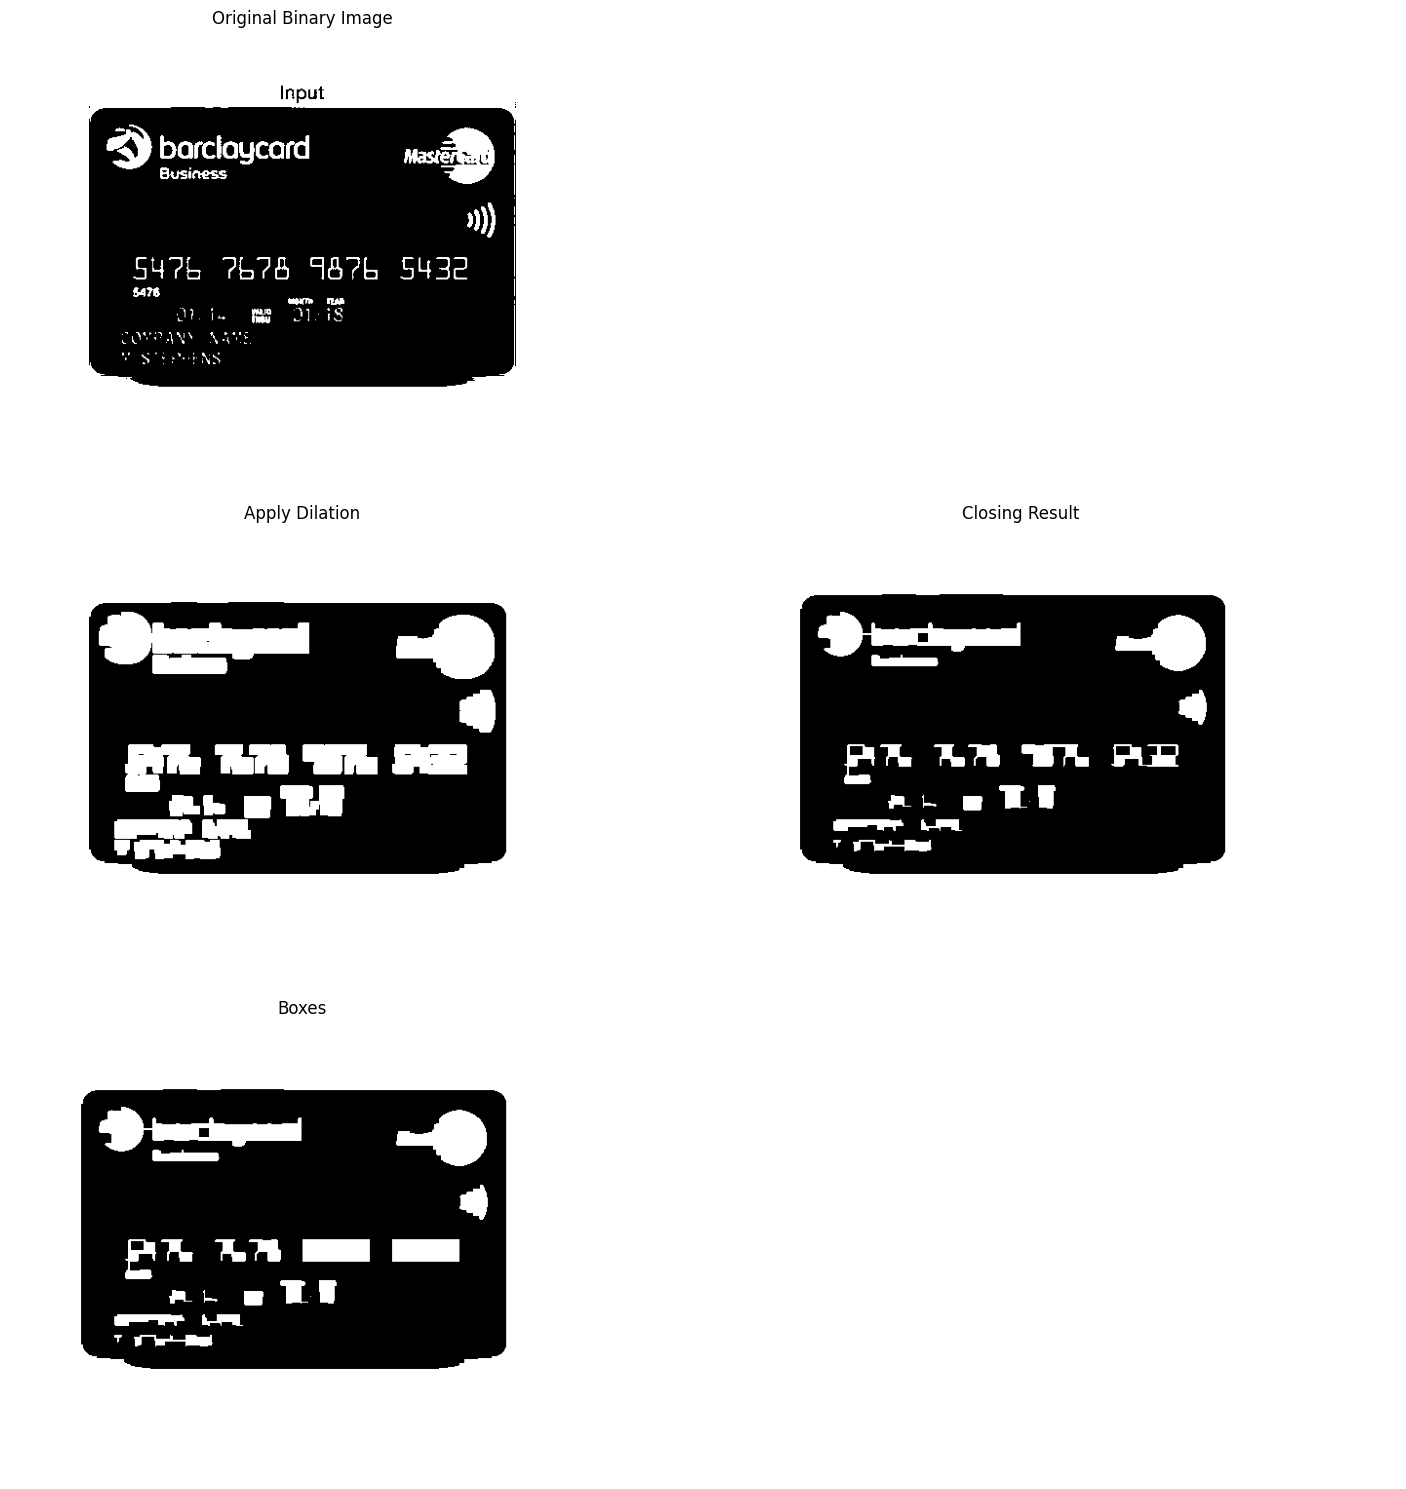

In [54]:
'''
2) Case Study: Credit Card Number Extraction
    - Load "card.jpg" from the img folder
    - Convert the image to binary by brightness thresholding maintaining the card number details for extraction
    - Use your erosion/dilation functions, or Skimage's functions only if you didn't implement them, to apply closing
        Note: The goal of this step is to join the card number into 4 sets of connected pixels
    - Use Skimage's "find_contours" to get the bounding boxes for the credit card's numbers by filtering on aspect ratio (between 2.5 & 3.5)
        Note: When using "find_contours(img, 0.8)" the o/p is a list of contours each having:
                - contour[:,0] being the Y values of the contour perimeter points
                - contour[:,1] being the X values of the contour perimeter points
'''
card_img = io.imread('img/card.jpg')
card_img_gray = rgb2gray(card_img)
brightness_threshold = 0.6
binary_card_img = card_img_gray > brightness_threshold


SE_size = 9
dilated_card_img = dilation(binary_card_img, SE_size)
closing_res = erosion(dilated_card_img, SE_size)


contours = measure.find_contours(closing_res, 0.8)
bounding_boxes = []
for contour in contours:
    ymin, ymax = np.min(contour[:, 0]), np.max(contour[:, 0])
    xmin, xmax = np.min(contour[:, 1]), np.max(contour[:, 1])
    width, height = xmax - xmin, ymax - ymin

    aspect_ratio = width / height 

    if 2.5 <= aspect_ratio <= 3.5:  
        bounding_boxes.append([xmin, xmax, ymin, ymax])

img_with_boxes = np.copy(closing_res) 
#When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = box
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=card_img_gray.shape)
    img_with_boxes[rr, cc] = 1 #set color white





fig, ax = plt.subplots(3, 2, figsize=(15, 15))

ax[0, 0].imshow(binary_card_img, cmap='gray')
ax[0, 0].set_title('Original Binary Image')
ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[1, 0].imshow(dilated_card_img, cmap='gray')
ax[1, 0].set_title('Apply Dilation')
ax[1, 0].axis('off')
ax[1, 1].imshow(closing_res, cmap='gray')
ax[1, 1].set_title('Closing Result')
ax[1, 1].axis('off')
ax[2, 0].imshow(img_with_boxes, cmap='gray')
ax[2, 0].set_title('Boxes')
ax[2, 0].axis('off')
ax[2, 1].axis('off')
plt.tight_layout()
plt.show()

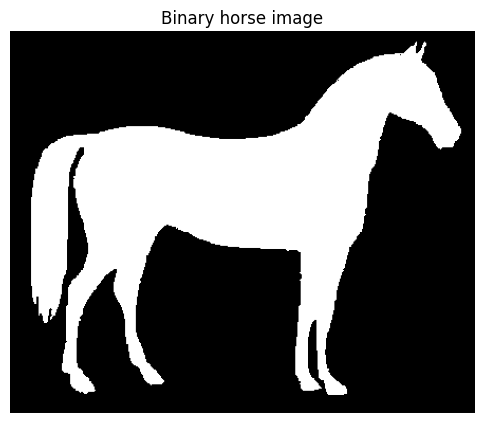

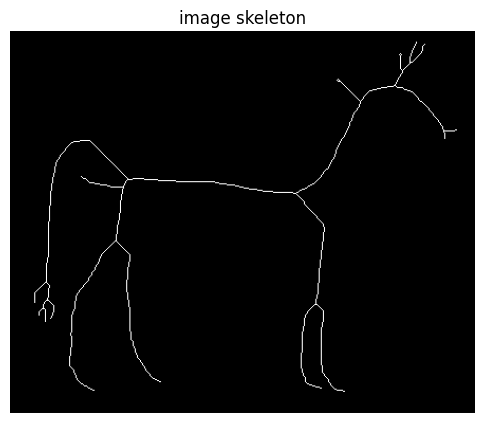

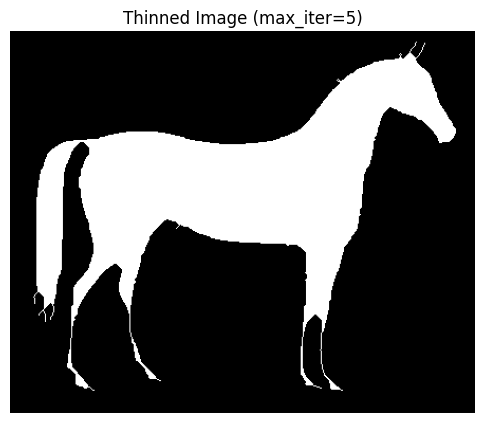

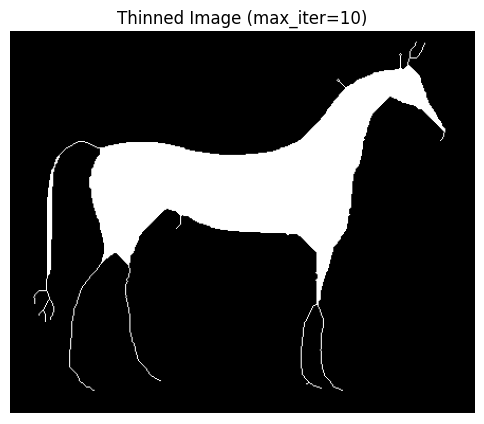

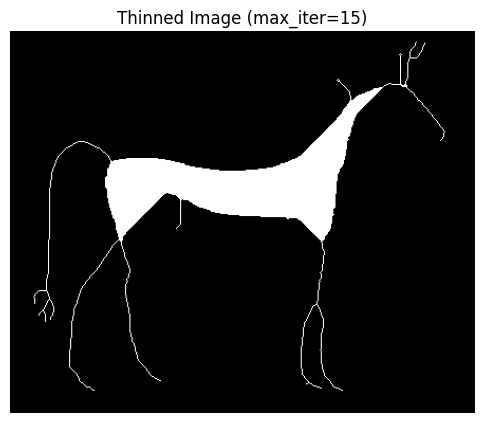

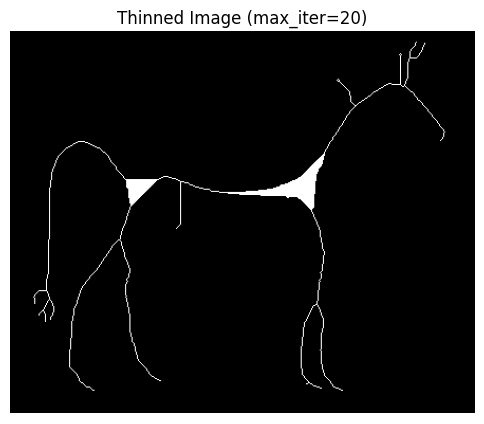

In [ ]:
'''
3) Skeletonization:
    - Load "horse.jpg" from the img folder 
    - Use a binary threshold of 0.9 to remove invisible noise in the background
    - Use Skimage's "skeletonize(image)" to acquire the image's skeleton & show it
    - Use Skimage's "thin(image, max_iter)" with values of max_iter 5/10/15/20 & show it
'''
# Skeletonization is a morphological operation in image processing that reduces a binary object in an image 
# to a thin, central line while preserving its topology. This central line, called the skeleton, 
# represents the general shape and connectivity of the object but in a minimal form.
horse_img = io.imread('img/horse.jpg')
gray_hores_img = rgb2gray(horse_img)

brightness_threshold = 0.9
bin_horse_img = gray_hores_img > brightness_threshold
plt.figure(figsize=(6, 6))
plt.imshow(bin_horse_img, cmap="gray")
plt.title("Binary horse image")
plt.axis("off")
plt.show()

img_skeleton = skeletonize(bin_horse_img)
plt.figure(figsize=(6, 6))
plt.imshow(img_skeleton, cmap="gray")
plt.title("image skeleton")
plt.axis("off")
plt.show()


# Thinning is a morphological operation similar to skeletonization, but with a slightly different focus. 
# While skeletonization reduces a binary shape to its "skeleton" (central line) while preserving topology, 
# thinning iteratively removes pixels from the outer layers of the object without necessarily reducing it to a single-pixel-wide skeleton.
max_iter_values = [5, 10, 15, 20]

for max_iter in max_iter_values:
    thinned_img = thin(bin_horse_img, max_num_iter=max_iter)
    plt.figure(figsize=(6, 6))
    plt.imshow(thinned_img, cmap="gray")
    plt.title(f"thinned Image (max_iter={max_iter})")
    plt.axis("off")
    plt.show()

